In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from datasets import DataCifar10
from models import ThreeLayerConvNet
from models.layers import Conv, ConvNaive, MaxPool, MaxPoolNaive
from optimers import OptimerAdam, OptimerSGD
from utils import check_rel_error, check_gradient, check_accuracy, show_training_info

In [2]:
dataloader = DataCifar10('./datasets/cifar-10-batches-py', 
                         num_train=49000, num_test=1000, num_val=100)

print('Training data shape: ', dataloader.x_train.shape)
print('Training labels shape: ', dataloader.y_train.shape)
print('Validating data shape: ', dataloader.x_val.shape)
print('Validating labels shape: ', dataloader.y_val.shape)
print('Testing data shape: ', dataloader.x_test.shape)
print('Testing labels shape: ', dataloader.y_test.shape)

Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validating data shape:  (100, 3, 32, 32)
Validating labels shape:  (100,)
Testing data shape:  (1000, 3, 32, 32)
Testing labels shape:  (1000,)


# Sanity Check

###  Image processing via convolutions

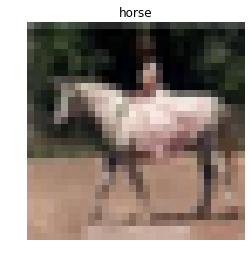

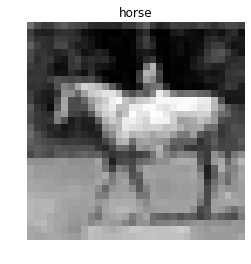

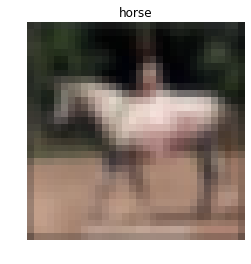

In [3]:
# get a image
images, labels = dataloader.get_batch(1)

# identical filter
conv = Conv(3, 3, 3, 3, S=1, P=1)
b = np.zeros(3)
W = np.zeros([3, 3, 3, 3])
W[0, 0, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
W[1, 1, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
W[2, 2, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

images_i, _ = conv.forward(images, {'W': W, 'b': b})

# grey filter
conv = Conv(3, 1, 3, 3, S=1, P=1)
b = np.zeros(1)
W = np.zeros([1, 3, 3, 3])
W[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

images_g, _ = conv.forward(images, {'W': W, 'b': b})

# other filter
conv = Conv(3, 3, 3, 3, S=1, P=1)
b = np.zeros(3)
W = np.zeros([3, 3, 3, 3])
W[0, 0, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]
W[1, 1, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]
W[2, 2, :, :] = [[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]]

images_u, _ = conv.forward(images, {'W': W, 'b': b})

# show image
dataloader.show_by_data(images_i[0], labels[0])
dataloader.show_by_data(images_g[0], labels[0])
dataloader.show_by_data(images_u[0], labels[0])

### Compare img2col/col2img with naive implementation

In [4]:
# get a image
images, labels = dataloader.get_batch(1)

# for conv layer
conv = Conv(3, 3, 3, 3, S=1, P=1)
conv_naive = ConvNaive(3, 3, 3, 3, S=1, P=1)
param = conv.get_init_param()

result, _ = conv.forward(images, param)
result_naive, _ = conv_naive.forward(images, param)

print('Relative error of conv layer:', check_rel_error(result , result_naive))

# for max pooling layer
pool = MaxPool(2, 2, S=2)
pool_naive = MaxPoolNaive(2, 2, S=2)

result, _ = pool.forward(images, {})
result_naive, _ = pool_naive.forward(images, {})

print('Relative error of max pooling layer:', check_rel_error(result , result_naive))


Relative error of conv layer: 5.8789671229908535e-08
Relative error of max pooling layer: 0.0


### Gradient check

In [5]:
def get_init_model(hyperparams):
    return ThreeLayerConvNet((3, 32, 32), 10, hyperparams=hyperparams)

# init model
model = get_init_model({'init_scale': 1e-2, 'num_filter': 3, 'num_hidden': 5})

# gradient check
print('\nGradient check result:')
check_gradient(model, dataloader.x_train[0: 10, :], dataloader.y_train[0: 10])


Gradient check result:
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.Conv'> W 0.05179121853604584 0.051798702904202874 0.0001444999292011571
<class 'models.layers.Conv'> b -0.00012771985691273358 -0.00012771985113857356 4.520957259953775e-08
<class 'models.layers.Linear'> W 0.012434957574747328 0.01243495758228845 6.064453531854856e-10
<class 'models.layers.Linear'> b 0.002376410757065628 0.002376410756600663 1.9565846132576397e-10
<class 'models.layers.Linear'> W 0.010149729945396757 0.01014972994691378 1.494643332072369e-10
<class 'models.layers.Linear'> b -0.0005509587452934284 -0.0005509587643794337 3.46414412659267e-08


### Overfit small dataset

In [6]:
# load small dataset
smallloader = DataCifar10('./datasets/cifar-10-batches-py', 
                          num_train=100, num_test=100, num_val=100)

# init model
model = get_init_model({'reg': 0., 
                        'filter_size': 7,
                        'num_filter': 32, 
                        'num_hidden': 100, 
                        'init_scale': 1e-2})

optimer = OptimerAdam({'learn_rate': 1e-3, 
                       'num_iters': 100, 
                       'batch_size': 50}, print_every=10)

# train model
optimer.train(model, smallloader)

# save model
model.save('./saves/ThreeLayerConvNet/model_small.pkl')

0 / 100 loss is 2.601186965900634
10 / 100 loss is 2.1436750431049325
20 / 100 loss is 1.343546190644838
30 / 100 loss is 0.6297988087684897
40 / 100 loss is 0.13651334991478928
50 / 100 loss is 0.03789402218896188
60 / 100 loss is 0.016003322507068474
70 / 100 loss is 0.01945929224529307
80 / 100 loss is 0.01031619780917714
90 / 100 loss is 0.01048543797703293


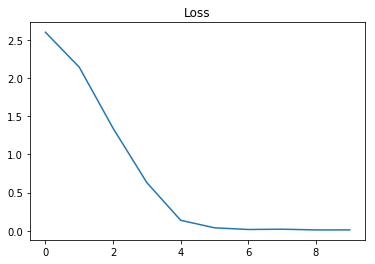

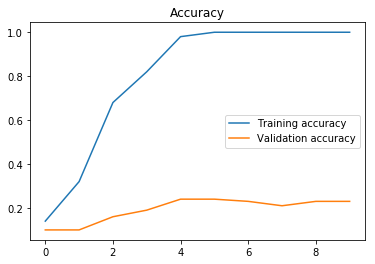

In [7]:
# plot loss curve
show_training_info(optimer)

In [9]:
# load model
model = ThreeLayerConvNet()
model.load('./saves/ThreeLayerConvNet/model_small.pkl')

# check accuracy
scores = model.predict(smallloader.x_test)
accuracy = check_accuracy(scores, smallloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.12


# Train 3-layer convnet

In [11]:
# init model
model = get_init_model({'reg': 0.01, 
                        'filter_size': 7,
                        'num_filter': 32, 
                        'num_hidden': 500, 
                        'init_scale': 1e-3})

optimer = OptimerAdam({'learn_rate': 1e-4, 
                       'learn_rate_decay':0.8,
                       'num_iters': 10000, 
                       'batch_size': 64}, print_every=100)

# train model
optimer.train(model, dataloader)

# save model
model.save('./saves/ThreeLayerConvNet/model.pkl')

0 / 10000 loss is 2.3232238405906163
100 / 10000 loss is 2.170192833534839
200 / 10000 loss is 1.9385105533940545
300 / 10000 loss is 1.7486496421394757
400 / 10000 loss is 1.6488785776656472
500 / 10000 loss is 1.7984916521006307
600 / 10000 loss is 1.5403184437090798
700 / 10000 loss is 1.7109441691119245
800 / 10000 loss is 1.2686219238978438
900 / 10000 loss is 1.3187309394840745
1000 / 10000 loss is 1.4525718986914051
1100 / 10000 loss is 1.4146489262832183
1200 / 10000 loss is 1.4539469248075625
1300 / 10000 loss is 1.2641733618831448
1400 / 10000 loss is 1.397223603896143
1500 / 10000 loss is 1.268911952285924
1600 / 10000 loss is 1.3716131834907146
1700 / 10000 loss is 1.248670387844385
1800 / 10000 loss is 1.4614190063958266
1900 / 10000 loss is 1.1177854883926073
2000 / 10000 loss is 1.385941425493822
2100 / 10000 loss is 1.3280310187578162
2200 / 10000 loss is 1.270276856258146
2300 / 10000 loss is 1.3617826091604406
2400 / 10000 loss is 1.2192145974404156
2500 / 10000 loss 

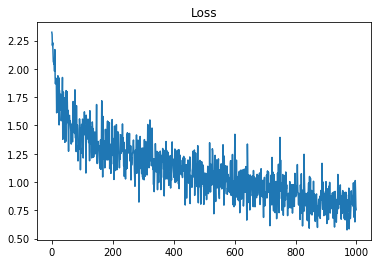

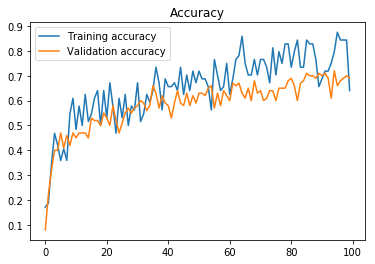

In [12]:
# plot loss curve
show_training_info(optimer)

In [13]:
# load model
model = ThreeLayerConvNet()
model.load('./saves/ThreeLayerConvNet/model.pkl')

# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.628
